In [2]:

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import torch.backends.cudnn as cudnn
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy
import random
import pandas as pd
import numpy as np
from glob import glob
import scipy
import torchvision.transforms as T
from PIL import Image
import json
import glob
from tqdm.notebook import tqdm
import warnings

warnings.filterwarnings("ignore")
     

In [3]:
IMAGE_SIZE = [224 , 224]

In [4]:
train_diretory = './Data/Training Data modified/Training Data modified/'
test_diretory = './Data/Testing Data modified/Testing Data modified/'
val_diretory = './Data/Validation Data modified/Vaildation Data modified/'

In [5]:
'''folders = glob('./Data/Training Data modified/Training Data modified/*')
len(folders)'''

"folders = glob('./Data/Training Data modified/Training Data modified/*')\nlen(folders)"

In [6]:
cwd = os.getcwd()

ROOT_DIR = os.path.join(cwd, "Data/Training Data modified/Training Data modified")

labels = {}

for folder in os.listdir(ROOT_DIR):
    for file in os.listdir(os.path.join(ROOT_DIR, folder)):
        if file.endswith(".jpg") or file.endswith(".jpeg") or file.endswith(".png"):
            full_name = os.path.join(ROOT_DIR, folder, file)
            labels[full_name] = folder

files = labels.keys()

In [7]:
dinov2_vits14 = torch.hub.load("facebookresearch/dinov2", "dinov2_vits14")
device = torch.device('cuda' if torch.cuda.is_available() else "cpu")
dinov2_vits14.to(device)
transform_image = T.Compose([T.ToTensor(), T.Resize(244), T.CenterCrop(224), T.Normalize([0.5], [0.5])])

Using cache found in /home/rokasb/.cache/torch/hub/facebookresearch_dinov2_main


In [8]:
def load_image(img: str) -> torch.Tensor:
    """
    Load an image and return a tensor that can be used as an input to DINOv2.
    """
    img = Image.open(img)

    transformed_img = transform_image(img)[:3].unsqueeze(0)

    return transformed_img

def compute_embeddings(files: list) -> dict:
    """
    Create an index that contains all of the images in the specified list of files.
    """
    all_embeddings = {}
    
    with torch.no_grad():
      for i, file in enumerate(tqdm(files)):
        embeddings = dinov2_vits14(load_image(file).to(device))

        all_embeddings[file] = np.array(embeddings[0].cpu().numpy()).reshape(1, -1).tolist()

    with open("all_embeddings.json", "w") as f:
        f.write(json.dumps(all_embeddings))

    return all_embeddings

In [9]:
embeddings = compute_embeddings(files)

  0%|          | 0/10000 [00:00<?, ?it/s]

In [10]:
from sklearn import svm

clf = svm.SVC(gamma='scale')

In [11]:

y = [labels[file] for file in files]

print(len(embeddings.values()))

embedding_list = list(embeddings.values())

clf.fit(np.array(embedding_list).reshape(-1, 384), y)

print(np.array(embedding_list).reshape(-1, 384))

10000
[[-0.99110413  2.46310711 -1.04587734 ... -0.41883004 -0.02407139
   2.00975561]
 [ 2.40632749  1.30864286 -3.11871409 ... -0.42658898 -0.69223446
   1.81230605]
 [ 2.85136557  0.01210673 -5.12617064 ...  1.1792742   3.64849257
   2.33891892]
 ...
 [ 0.58431542  3.15778327  1.39543557 ...  2.14401984 -0.07121381
  -0.10946686]
 [-0.47157219  1.79584062  2.58868456 ...  2.49605751  1.10491323
   2.09674072]
 [-0.79486984  1.39201319  1.4976747  ...  0.91640002  2.38112688
   0.81148082]]


In [12]:
input_file = "Data/Training Data modified/Training Data modified/Cat/Cat-Train (1).jpg"

new_image = load_image(input_file)

with torch.no_grad():
    embedding = dinov2_vits14(new_image.to(device))

    prediction = clf.predict(np.array(embedding[0].cpu()).reshape(1, -1))

    print("Predicted class: " + prediction[0])

Predicted class: Cat


In [13]:
paths = glob.glob("Data/Testing Data modified/Testing Data modified/*")

correct = 0
predicted = 0

for path in paths:
    label = path.split("/")[-1]
    for image_path in glob.glob(f"{path}/*"):
        new_image = load_image(image_path)
        with torch.no_grad():
            embedding = dinov2_vits14(new_image.to(device))
            prediction = clf.predict(np.array(embedding[0].cpu()).reshape(1, -1))
            predicted += 1
            if prediction[0] == label:
                correct += 1

accuracy = correct / predicted
print("Test accuracy: ", accuracy)
print(predicted)


Test accuracy:  0.9918509895227008
859


In [14]:
paths = glob.glob("Data/Validation Data modified/Validation Data modified/*")

correct = 0
predicted = 0

for path in paths:
    label = path.split("/")[-1]
    for image_path in glob.glob(f"{path}/*"):
        new_image = load_image(image_path)
        with torch.no_grad():
            embedding = dinov2_vits14(new_image.to(device))
            prediction = clf.predict(np.array(embedding[0].cpu()).reshape(1, -1))
            predicted += 1
            if prediction[0] == label:
                correct += 1

accuracy = correct / predicted
print("Validation accuracy: ", accuracy)
print(predicted)


Validation accuracy:  1.0
700


['Butterfly']


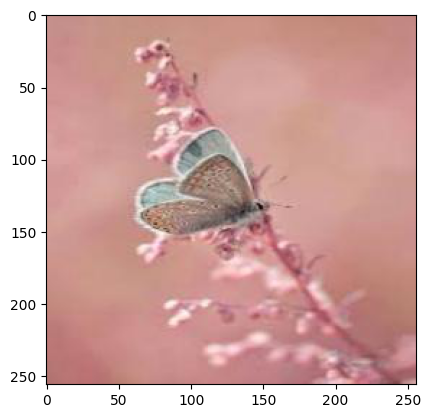

['Cat']


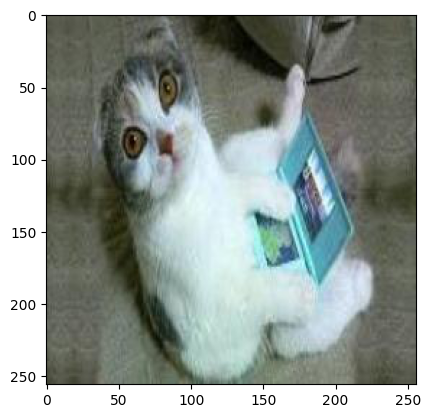

['Butterfly']


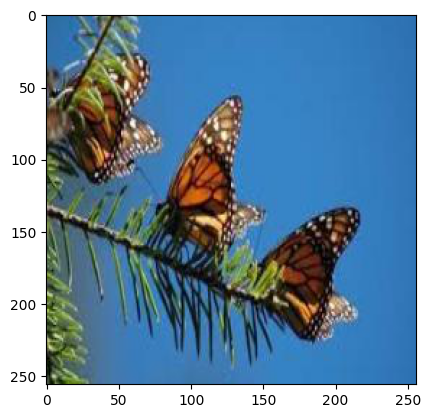

['Beetle']


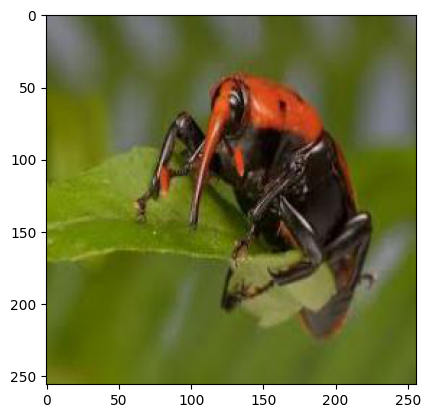

['Cow']


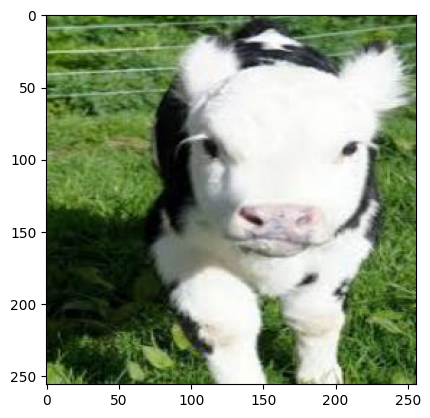

['Cat']


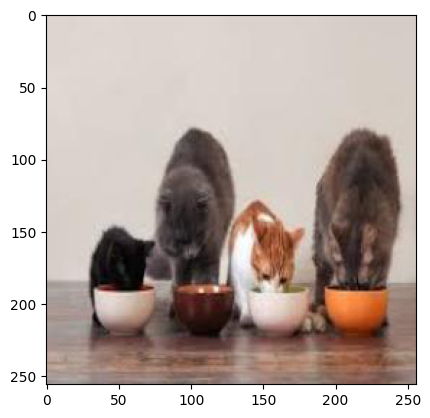

['Beetle']


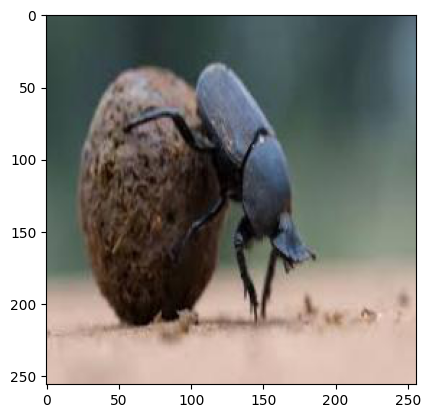

['Cow']


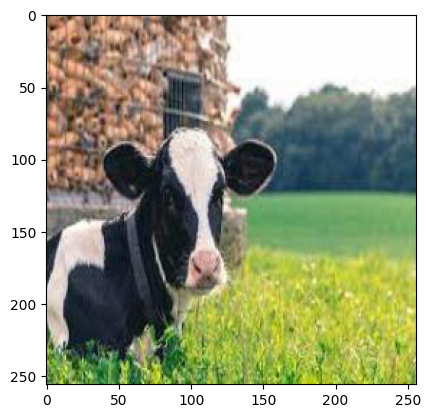

['Cow']


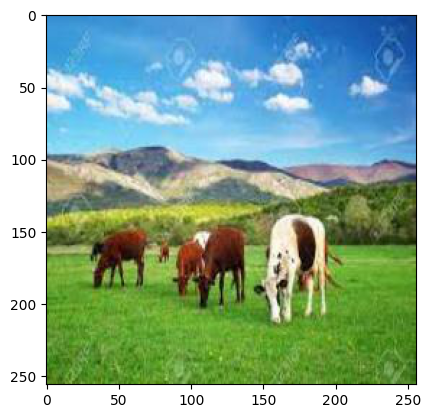

['Cat']


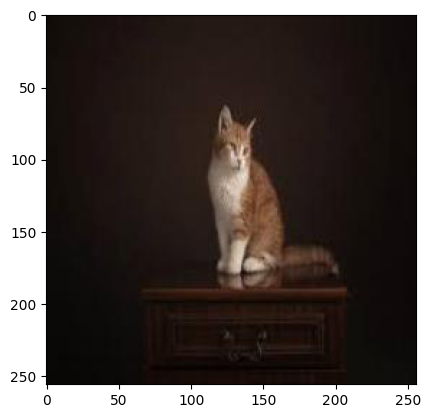

In [19]:
#predict 10 random images from test set
import random
import os
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from PIL import Image
import numpy as np
from glob import glob

test_dir = './Data/Testing Data modified/Testing Data modified/'
test_files = os.listdir(test_dir)
test_imgs = [os.path.join(test_dir, f) for f in test_files]
test_imgs = glob('./Data/Testing Data modified/Testing Data modified/*/*')

for i in range(20):
    path = random.choice(test_imgs)
    pic = mpimg.imread(path)
    new_image = load_image(path)
    with torch.no_grad():
        embedding = dinov2_vits14(new_image.to(device))
        prediction = clf.predict(np.array(embedding[0].cpu()).reshape(1, -1))
        print(prediction)
        plt.imshow(pic)
        plt.show()

